# Boundary conditions

To solve the differential equation problems involved in SeisCL modelisation, we obviously need to set boundary conditions. Dirichelet boundary condition can't be used effectively in numerical simulation since it causes artificials reflections. To minimise those reflections, we then want to use absorbings boundaries around our domain.

Two absorbing boundary type are implemented : the convolutional perfectly matched layer (CPML) [Komatitsch and Martin (2007)](https://doi.org/10.1190/1.2757586) and the dissipative layer of [Cerjan, et al., 1985](https://doi.org/10.1190/1.1441945).

## Theory

### 1. Cerjan

Cerjan et Al. have described a simple absorbing boundary layer in which the numerical grid is enlarged by a few grid points (typically 30 grid points) in each direction. The values of the stress and particle velocity in this boundary frame are multiplied by a factor "damp" : 

$$ \textrm{damp} = e^{-a^2 x^2}$$

with $ a = \sqrt{\dfrac{-\log(\textrm{amp})}{\textrm{FW}}} $ and $\textrm{amp} = 0.92$. The seismic waves are damped inside the boundary frame and cannot be reflected back into the model.

<br>

However, with Cerjan's simple formulation, the wavefield is still partialy reflected at the boundary between the absorbent layer and the model.

<br>

### 2. PML

The perfectly matched layer distinguishes itself from an ordinary absorbing material by being designed so that waves incident upon the PML from a non-PML medium do not reflect at the interface. This property allows the PML to strongly absorb outgoing waves from the interior of a computational region without reflecting them back into the interior.

First derived by [Berenger](https://doi.org/10.1006/jcph.1994.1159), the idea behind PML is to use a coordinate transformation into complex coordinates replacing propagating (oscillating) waves by exponentially decaying waves. In SeisCL, Komiatitsch formulation is used where :

$$ \tilde{x}\,(x) = x - \frac{i}{\omega} \int_{0}^{x} d_x(s) \, ds  \qquad \rightarrow  \qquad \tilde{\partial_{x}}=\frac{\mathrm{i} \omega}{\mathrm{i} \omega+d_{x}} \partial_{x} $$


where $\omega$  is the angular frequency and $d_x(s)$ is a damping profile in x. Wherever $d_x(s)$ is positive, propagating waves are attenuated because:

<br>

$$ \normalsize e^{-i(\mathbf{k} \tilde{x} - \omega t)} \qquad \rightarrow \qquad  e^{-\mathbf{i}(\mathbf{k} \cdot \mathbf{x}-\omega t)} e^{-k_{x} / \omega \int_{0}^{x} d_{x}(s) \mathrm{d} s} $$

<br>


<!-- Let us note that this damping coefficient depends on the direction of propagation of the wave, and is large for a wave propagating close to normal incidence, but becomes significantly smaller for a wave propagating at grazing incidence,
which explains the reduced efficiency of the classical PML model at grazing incidence. Let us also note that the reflection coefficient between the medium and the PML region is exactly zero for all angles of incidence and all frequencies here, before discretization by a numerical scheme, hence the name perfectly matched layer. -->


In the PML formulation, the damping coefficient depends on the direction of propagation of the wave, and is large for a wave propagating close to normal incidence, but becomes significantly smaller for a wave propagating at grazing incidence. It is always important to note that PML is only reflectionless for the exact wave equation and once discretized, some numerical reflections appear. With increasing resolution, those gradually vanish.

## Boundaries interactions with sources and receivers

A capital consideration to have with absorbing boundary conditions is to make sure that the absorbings layers won't  interfer with the sources and the receiver. Indeed, if either of them is located at the same grid point as the absorbing layer, the received wave will be greatly attenuated.
<br>

It is therefore important to set the position of both of them on the outside of the layer. It's also a good pratice to add a small buffer t0 remove any interference the PML could have on the result. Here the buffer is twice the size of the order of the finite difference.

As usual we import the relevant modules and we define the basic constants.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seisPML = SeisCL()

In [2]:
seisPML.csts['ND'] = 2
seisPML.csts['N'] = np.array([250, 500])
seisPML.csts['dt'] = dt = 0.25e-03
seisPML.csts['dh'] = dh = 2
seisPML.csts['NT'] = NT = 1500
seisPML.csts['FDORDER'] = 4

In the `csts` dictionnay, the thickness of the absorbing layer is set with `nab`. Let's put it to 15 pts to start.

In [4]:
Nz = seisPML.csts['N'][0]
Nx = seisPML.csts['N'][1]

seisPML.csts['abs_type'] = 1
seisPML.csts['nab'] = nab = 15
nbuf = seisPML.csts['FDORDER'] * 2

sx = (nab + nbuf) * dh
sy = 0
sz = (nab + nbuf) * dh
offmin = 20 * dh
offmax = (Nx - nab - nbuf) * dh - offmin
gx = np.arange(sx + offmin, sx + offmax, 8*dh)
gy = gx * 0
gz = gx * 0 + (nab + nbuf) * dh
offset = gx-sx

seisPML.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seisPML.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)

Let's take the same three-layer model that we created in the [Model Building](Model_Building.ipynb) notebook.

In [6]:
vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Ep_vp = [Nz//5, Nz//3]

vp_1 = np.zeros((Ep_vp[0], Nx)) + vp[0]
vp_2 = np.zeros((Ep_vp[1], Nx)) + vp[1]
vp_3 = np.zeros((Nz-np.sum(Ep_vp), Nx)) + vp[2]

vp_all = np.vstack((vp_1, vp_2, vp_3))

vs_all = np.zeros(seisPML.csts['N']) + vs
rho_all = np.zeros(seisPML.csts['N']) + rho
taup_all = np.zeros(seisPML.csts['N']) + taup
taus_all = np.zeros(seisPML.csts['N']) + taus


Model3Layers = {"vp": vp_all, "rho": rho_all, "vs": vs_all, "taup": taup_all, "taus": taus_all}

Now we can visualize the geometry, source, receivers and boundary layers to make sure that no interference will take place.

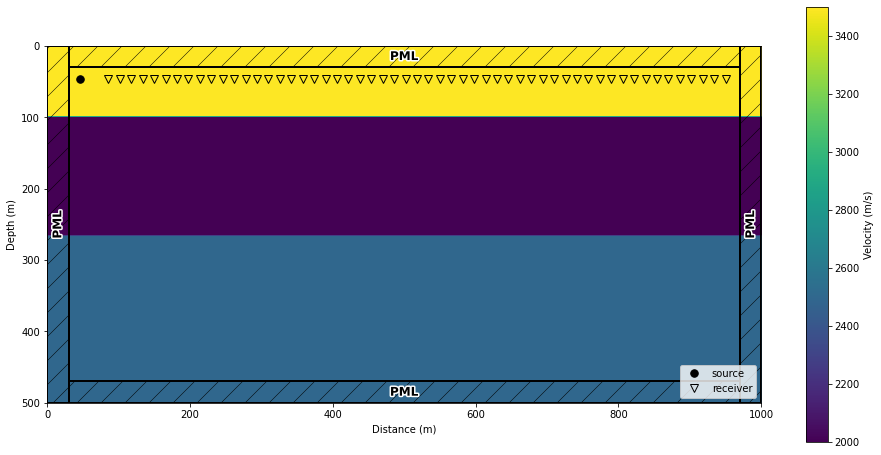

In [8]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seisPML.DrawDomain2D(vp_all, ax = ax, ShowAbs = True, ShowSrcRec = True)

## Comparison with Cerjan layer

Let's create a copy of our `SeisCL()` class and let's just change the parameter `abs_type = 2` to have a cerjan layer.

In [9]:
from copy import deepcopy

seisCerjan = deepcopy(seisPML)
seisCerjan.csts['abs_type'] = 2

Now we launch the simulation for both of them.

In [10]:
seisPML.set_forward(gsid, Model3Layers, withgrad=False)
InfoPML = seisPML.execute()
dataPML = seisPML.read_data()

seisCerjan.set_forward(gsid, Model3Layers, withgrad=False)
InfoCerjan = seisCerjan.execute()
dataCerjan = seisCerjan.read_data()

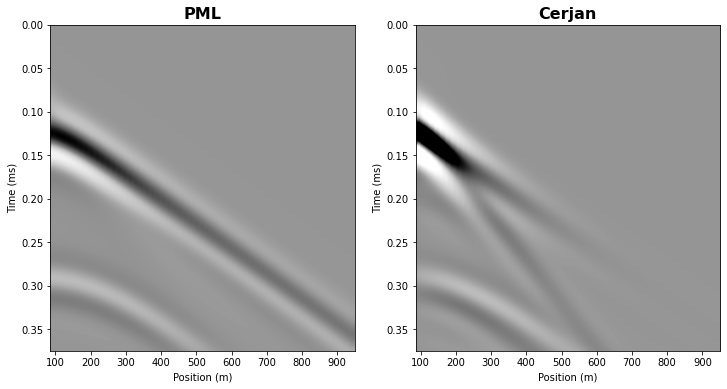

In [12]:
_, ax = plt.subplots(1, 2, figsize=[12, 6])
extent = [min(gx), max(gx), (dataPML.shape[0]-1)*dt, 0]
clip = 1
vmax = np.max(dataPML) * clip
vmin = -vmax
ax[0].imshow(dataPML, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[0].set_title("PML", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Position (m)")
ax[0].set_ylabel("Time (ms)")

ax[1].imshow(dataCerjan, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[1].set_title("Cerjan", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Position (m)")
ax[1].set_ylabel("Time (ms)")

plt.show()

As we can see, the PML create a lot less reflection.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from SeisCL import SeisCL
seisPML = SeisCL()

In [14]:
seisPML.csts['ND'] = 2
seisPML.csts['N'] = np.array([250, 500])
seisPML.csts['dt'] = dt = 0.25e-03
seisPML.csts['dh'] = dh = 2
seisPML.csts['NT'] = NT = 1500
seisPML.csts['FDORDER'] = 4

In [15]:
Nx = seisPML.csts['N'][0]
Ny = seisPML.csts['N'][1]

vp = [3500, 2000, 2500]
vs = 2000
rho = 2000
taup = 0
taus = 0

Ep_vp = [Nx//3, Nx//5]

vp_a = np.vstack((np.zeros((Ep_vp[0], Ny))+vp[0],
                np.zeros((Ep_vp[1], Ny))+vp[1],
                np.zeros((Nx-np.sum(Ep_vp), Ny))+vp[2]))

vs_a = np.zeros(seisPML.csts['N']) + vs
rho_a = np.zeros(seisPML.csts['N']) + rho
taup_a = np.zeros(seisPML.csts['N']) + taup
taus_a = np.zeros(seisPML.csts['N']) + taus

Model3Layers = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}

In [16]:
seisPML.csts['abs_type'] = 2
seisPML.csts['nab'] = nab = 50
seisPML.csts['abpc'] = 6
nbuf = seisPML.csts['FDORDER'] * 2

sx = (nab + nbuf) * dh
sy = 0
sz = (nab + nbuf) * dh
offmin = 20 * dh
offmax = (Ny - nab) * dh - offmin
gx = np.arange(sx + offmin, offmax, 5*dh)
gy = gx * 0
gz = gx * 0 + (nab + nbuf) * dh
offset = gx-sx

seisPML.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)

gsid = gz * 0
gid = np.arange(0, len(gz))
seisPML.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)

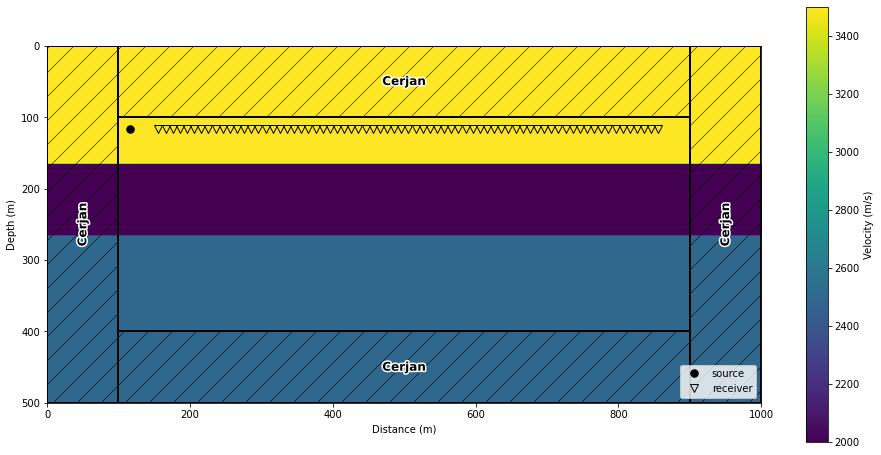

In [17]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seisPML.DrawDomain2D(vp_a, ax = ax, ShowAbs = True, ShowSrcRec = True)

In [18]:
seisPML.set_forward(gsid, Model3Layers, withgrad=False)
seisPML.execute()
dataPML = seisPML.read_data()

In [19]:
from copy import deepcopy

seisCerjan = deepcopy(seisPML)
seisCerjan.csts['abs_type'] = 1

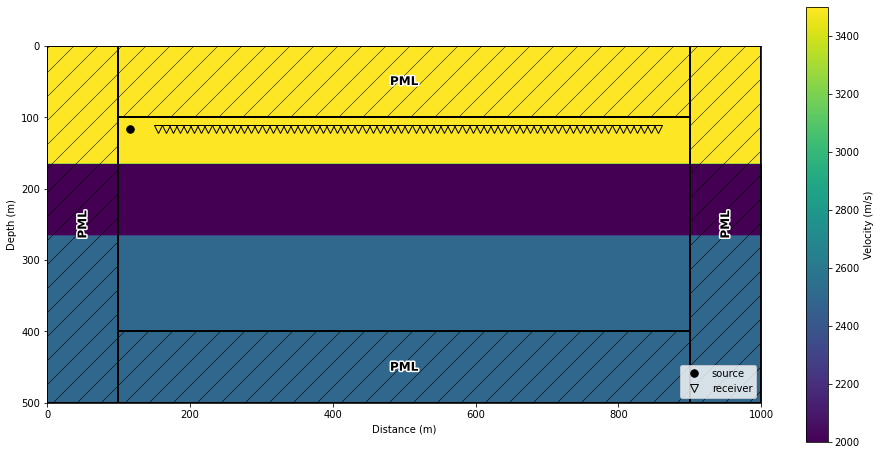

In [20]:
_, ax = plt.subplots(1, 1, figsize = (16,8))
seisCerjan.DrawDomain2D(vp_a, ax = ax, ShowAbs = True, ShowSrcRec = True)

In [21]:
seisCerjan.set_forward(gsid, Model3Layers, withgrad=False)
seisCerjan.execute()
dataCerjan = seisCerjan.read_data()

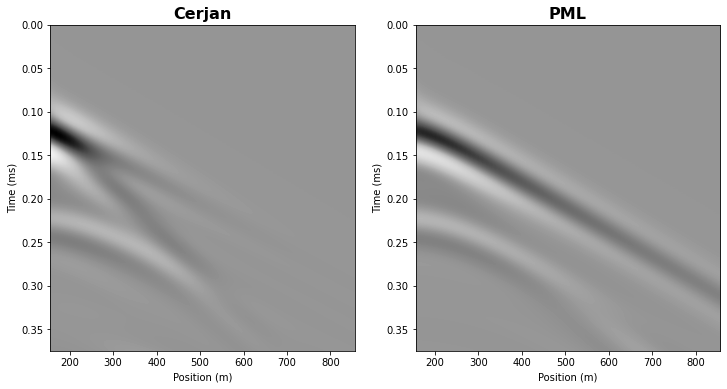

In [22]:
_, ax = plt.subplots(1, 2, figsize=[12, 6])
extent = [min(gx), max(gx), (dataPML.shape[0]-1)*dt, 0]
clip = 1
vmax = np.max(dataPML) * clip
vmin = -vmax
ax[0].imshow(dataPML, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[0].set_title("Cerjan", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Position (m)")
ax[0].set_ylabel("Time (ms)")

ax[1].imshow(dataCerjan, aspect='auto', vmax=vmax, vmin=vmin,
             extent=extent, interpolation='bilinear',
             cmap=plt.get_cmap('Greys'))
ax[1].set_title("PML", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Position (m)")
ax[1].set_ylabel("Time (ms)")

plt.show()